In [40]:
#!pip install reverse_geocoder
#!pip install plotly_express

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import plotly.graph_objects as go
import plotly_express as px


# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [65]:
# Output
#  df_ts_complete: df with values where time series is complete
#  df_estimate: df where all time series values are NaN but there is an estimate
#  df_ts_incomplete: df with values where at least one of time series values is NaN
# 
# Reads global powerplant data data from CSV, drops irrelevant columns, splits df (see output), 
# and re-indexes df with gppdf_idnr as index
def read_clean_and_split():  
    df = pd.read_csv("data\global_power_plant_database.csv")
    df_all = df.drop(['country_long', 'url', 'geolocation_source', 'wepp_id'], axis=1)
    
    df_ts = (df_all.dropna(how='all', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
                      .set_index('gppd_idnr'))
    df_ts_complete = df_ts.dropna(how='any', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
    df_estimate = (df_all.dropna(how='any', subset=['estimated_generation_gwh'])
                   .set_index('gppd_idnr'))
    df_ts_incomplete = df_ts[df_ts[['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']].isnull().any(axis=1)]
    return df_all, df_ts_complete, df_ts_incomplete, df_estimate     

In [66]:
df_all, df_ts_complete, df_ts_incomplete, df_estimate = read_clean_and_split()
df_all.head()

,country,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,owner,source,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh
0,AFG,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.00,32.3220,65.1190,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.00,34.5560,69.4787,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.00,34.6410,69.7170,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Nangarhar (Darunta) Hydroelectric Power Plant ...,GEODB0040536,11.55,34.4847,70.3633,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Northwest Kabul Power Plant Afghanistan,GEODB0040540,42.00,34.5638,69.1134,Gas,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN


# EDA
## 1. Plot distribution of capacity for each fuel type

In [22]:
# Group by the fuel type
fueltype = df_all.groupby("primary_fuel")
fueltype.describe()

capacity_mw                                             \
                     count         mean          std   min        25%   
primary_fuel                                                            
Biomass             1396.0    24.667408    39.970655   1.0     3.0000   
Coal                2390.0   836.619247   883.792022   1.2   200.0000   
Cogeneration          41.0    97.624390   283.717419   1.6     7.5000   
Gas                 3922.0   375.495683   562.794664   1.0    31.1250   
Geothermal           189.0    66.473810   114.770905   1.0    18.0000   
Hydro               7155.0   146.804321   549.433962   1.0     5.3000   
Nuclear              198.0  2069.832626  1304.270269  20.0  1100.0000   
Oil                 2290.0   114.565943   394.966198   1.0     2.5404   
Other                 44.0    85.399091   144.155122   4.5    17.5000   
Petcoke               13.0   192.082885   458.141449   4.7    27.3000   
Solar               5929.0    10.747651    26.418461   1.0     2.0000   
Storage               58.0     7.820690     9.682517   1.0     2.0000   
Waste               1087.0    13.898081    20.690791   1.0     2.3000   
Wave and Tidal        10.0    55.220000   101.440708   1.0     1.4000   
Wind                5188.0    46.299842   102.712898   1.0    10.0000   

                                            latitude             ...  \
                    50%       75%       max    count       mean  ...   
primary_fuel                                                     ...   
Biomass            9.95    29.175    528.00   1396.0  19.364704  ...   
Coal             600.00  1200.000   7000.00   2390.0  32.725796  ...   
Cogeneration      30.00    49.300   1404.00     41.0  38.124766  ...   
Gas              152.25   530.000   8865.00   3922.0  31.662952  ...   
Geothermal        30.00    77.000   1163.00    189.0  29.557186  ...   
Hydro             20.00    93.000  22500.00   7155.0  30.309767  ...   
Nuclear         1883.40  2665.025   8212.00    198.0  38.597543  ...   
Oil                9.20    50.000   6794.00   2290.0  14.116997  ...   
Other             40.00    98.625    845.26     44.0  38.899089  ...   
Petcoke           67.00   122.900   1707.30     13.0  31.472562  ...   
Solar              4.70     9.000    648.00   5929.0  40.678147  ...   
Storage            2.90    10.000     40.00     58.0  39.166022  ...   
Waste              4.90    15.250    160.90   1087.0  39.106433  ...   
Wave and Tidal     5.00    22.250    254.00     10.0  52.995930  ...   
Wind              26.00    49.000   6000.00   5188.0  36.618024  ...   

               generation_gwh_2017               estimated_generation_gwh  \
                               75%           max                    count   
primary_fuel                                                                
Biomass                 338.506503    831.165002                   1241.0   
Coal                   6262.190992  35116.000000                   1846.0   
Cogeneration            166.049000    564.213000                     11.0   
Gas                     530.573000  20515.369717                   2115.0   
Geothermal              303.664250   4667.659000                    127.0   
Hydro                   158.727375  20983.990000                   5438.0   
Nuclear               17592.001000  32340.138000                    128.0   
Oil                       0.732500   6972.247003                   1442.0   
Other                   128.024499    508.701000                     28.0   
Petcoke                 297.125749   5776.007940                      1.0   
Solar                     9.928000   1237.532000                   4567.0   
Storage                   0.056000     34.300000                      0.0   
Waste                    99.123750    928.862008                    538.0   
Wave and Tidal                 NaN           NaN                      0.0   
Wind                    374.916500   1972.964000                   4309.0   

                

Interpretation: 

TODO

In [24]:
capacity = fueltype.agg(**{'capacity_sum': pd.NamedAgg(column='capacity_mw', aggfunc='sum')})
capacity = capacity.sort_values(by='capacity_sum', ascending = False)
capacity

,capacity_sum
primary_fuel,
Coal,1.999520e+06
Gas,1.472694e+06
Hydro,1.050385e+06
Nuclear,4.098269e+05
Oil,2.623560e+05
Wind,2.402036e+05
Solar,6.372282e+04
Biomass,3.443570e+04
Waste,1.510721e+04


In [26]:
#Green fuels = 1, non-green fuels = 0, other = 2
green_map = dict.fromkeys(['Hydro', 'Nuclear', 'Wind', 'Solar', 'Biomass', 'Waste', 'Geothermal', 'Cogeneration', 'Wave and Tidal', 'Storage'], 1)
green_map.update(dict.fromkeys(['Coal', 'Gas', 'Oil', 'Petcoke'], 0))
green_map.update(dict.fromkeys(['Other'], -1))

In [34]:
capacity['is_green'] = capacity['primary_fuel'].apply(lambda x: green_map[x])


,level_0,index,primary_fuel,capacity_sum,is_green
0,0,0,Coal,1.999520e+06,0
1,1,1,Gas,1.472694e+06,0
2,2,2,Hydro,1.050385e+06,1
3,3,3,Nuclear,4.098269e+05,1
4,4,4,Oil,2.623560e+05,0
5,5,5,Wind,2.402036e+05,1
6,6,6,Solar,6.372282e+04,1
7,7,7,Biomass,3.443570e+04,1
8,8,8,Waste,1.510721e+04,1
9,9,9,Geothermal,1.256355e+04,1


In [32]:

plt.style.use('seaborn')
colors = {'0':"black", '1':"green", '-1':"grey"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
c = capacity['is_green'].apply(lambda x: colors[x])
plt.bar(capacity['primary_fuel'], capacity['capacity_sum'], color=capacity['is_green'], label=colors)
plt.xticks(rotation = 60)
plt.xlabel("Primary fuel type")
plt.ylabel("Total capacity (in Megawatts)", rotation = 90)
plt.legend(handles, labels)

KeyError: 0

**Interpretation:**

TODO

## 2. How many new powerplants in total and of each new fuel type per year (or per n years)

In [36]:
# https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
newpp = df_all[['gppd_idnr','country','primary_fuel','commissioning_year']]
newpp = newpp.dropna()
newpp['commissioning_year'] = newpp['commissioning_year'].map(int)
newyear = newpp.groupby('commissioning_year')

In [38]:
nycount = newyear.size()
nycount

commissioning_year
1896      1
1899      1
1900      6
1901      2
1902      4
       ... 
2014    819
2015    804
2016    860
2017    715
2018    175
Length: 121, dtype: int64

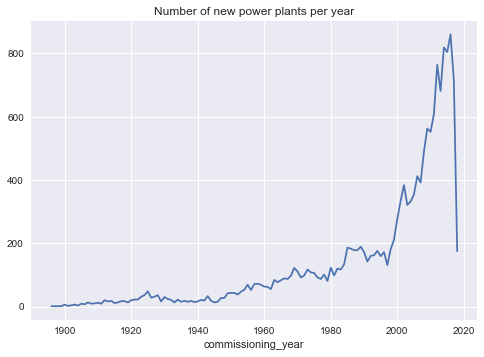

In [46]:
nycountplot = nycount.plot(title = "Number of new power plants per year")

**Interpretation:**

In [47]:
# However, the energy output data is available only until 2017. 
# We also see a suspicious drop in the amount of new power plants from 2017 to 2018.
# The latest technical note for the dataset was published in 2019, 
# but almost all sources used are from 2018 (also powerplant data sources).
# It seems likely that the dataset does not represent the number of new powerplants in 2018 adequately.
# Therefore, we only include the data from 1896-2017:
maskyear = newpp["commissioning_year"] != 2018
newpp = newpp[maskyear]
newyear = newpp.groupby('commissioning_year')
nycount = newyear.size()

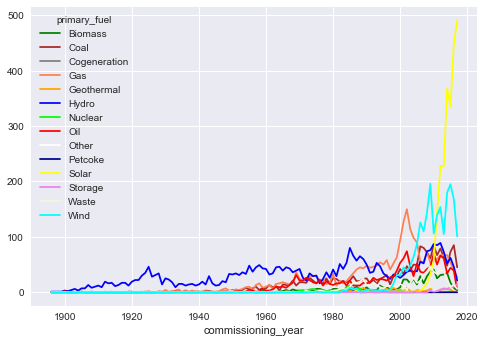

In [53]:
# Exploring which fuel types are responsible for the spikes:

# https://stackoverflow.com/questions/53997862/pandas-groupby-two-columns-and-plot
# https://matplotlib.org/stable/tutorials/colors/colors.html

pd.crosstab(newpp["commissioning_year"],newpp["primary_fuel"]).plot(color = ['green','brown','grey','coral','orange','blue','lime','red','white','darkblue','yellow','violet','beige','cyan'])

**Interpretation:**

In [55]:
# Exploring which countries are responsible for the spike in solar power plants:
masksolar = newpp["primary_fuel"] == 'Solar'
newsolar = newpp[masksolar]

,gppd_idnr,country,primary_fuel,commissioning_year
1549,BRA0031760,BRA,Solar,2014
2417,BRA0031430,BRA,Solar,2014
3093,BRA0030060,BRA,Solar,2011
6460,WRI1029337,CHN,Solar,2011
8487,WRI1030005,DNK,Solar,2016
...,...,...,...,...
29505,USA0057422,USA,Solar,2011
29512,USA0060107,USA,Solar,2015
29521,USA0060980,USA,Solar,2016
29522,USA0061257,USA,Solar,2017


TypeError: 'int' object is not callable

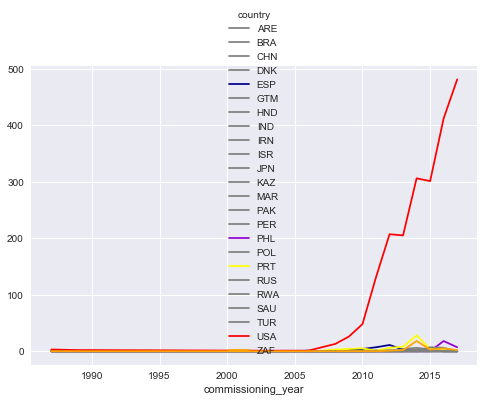

In [59]:
pd.crosstab(newsolar["commissioning_year"], newsolar["country"]).plot(color = ['grey','grey','grey','grey','darkblue','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','darkviolet','grey','yellow','grey','grey','grey','grey','red','orange'])
#plt.ylim(0,250) DO LATER
plt.legend(bbox_to_anchor=(1.2,1.1))

# Maps on full dataset

In [68]:
#fig = px.scatter_geo(df_all,
#                    lat=df_all["latitude"],
#                    lon=df_all["longitude"],
#                    hover_name=df_all["name"],
#                    color = df_all["primary_fuel"])
#fig.show(#)

In [70]:
#df = df.groupby(['country', 'primary_fuel'], as_index = False)[["capacity_mw"]].sum() # groups countries by primary fuel types along with their aggregate capacity
#df = df.sort_values(['country','capacity_mw'], ascending = [True, False], ignore_index = True) # sorts countries by maximum capacity for each fuel type
#df = df.drop_duplicates(subset=['country'], keep='first', ignore_index = True) # only keeps the fuel type with highest maximum capacity
#df

df_pf = (df_all.groupby(['country', 'primary_fuel'], as_index = False)[["capacity_mw"]].sum()
        .sort_values(['country','capacity_mw'], ascending = [True, False], ignore_index = True)
        .drop_duplicates(subset=['country'], keep='first', ignore_index = True))

In [77]:

# Try with dictionary???
colors = {'Solar':'yellow', 
          'Gas':'lightgreen', 
          'Oil':'olive', 
          'Wind':'cyan', 
          'Hydro':'blue', 
          'Coal':'black', 
          'Biomass':'green', 
          'Waste':'brown', 
          'Cogeneration':'bisque', 
          'Geothermal':'red', 
          'Nuclear':'orange', 
          'Petcoke':'teal', 
          'Other':'grey', 
          'Storage':'lime'}


# plots the countries based on the most used primary fuel types
fig = px.choropleth(df_pf, locations=df_pf["country"],
                    hover_name=df_pf["country"],
                    color = df_pf["primary_fuel"],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

# Complete Time Series Analysis

In [14]:
# Creates new column 'avg_annual_output' in df by
#  - copying estimated_generation_gwh in rows where it is not NaN
#  - averaging the time series in the remaining rows
def annual_output(df):
    df['avg_annual_output'] = df['estimated_generation_gwh']    
    idx = df.index[df['estimated_generation_gwh'].isna()].tolist()    
    df.loc[idx,'avg_annual_output'] = df[['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']].mean(axis=1)

In [16]:
annual_output(df_ts_complete)

In [17]:
df_ts_complete

,country,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,owner,source,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh,avg_annual_output
gppd_idnr,,,,,,,,,,,,,,,,,,,
AUS0000065,AUS,21.6,-35.0641,117.7977,Wind,NaN,NaN,NaN,NaN,Verve Energy,Australian Renewable Energy Mapping Infrastruc...,NaN,89.595278,102.642778,96.555556,95.872778,85.900278,NaN,94.113333
AUS0000264,AUS,55.6,-34.2082,150.7722,Gas,NaN,NaN,NaN,NaN,Energy Developments CSM (NSW) Pty Ltd,Australian Renewable Energy Mapping Infrastruc...,NaN,204.804444,238.294444,163.583611,158.933056,64.534722,NaN,166.030056
AUS0000049,AUS,1.1,-33.0250,151.5497,Waste,NaN,NaN,NaN,NaN,LMS Energy Generation Pty Ltd,Australian Renewable Energy Mapping Infrastruc...,NaN,7.655278,8.338611,9.172500,8.830000,8.085556,NaN,8.416389
AUS0000081,AUS,94.0,-37.8429,147.5639,Gas,NaN,NaN,NaN,NaN,Alinta DEBO,Australian Renewable Energy Mapping Infrastruc...,NaN,132.456667,154.885556,149.821111,197.540556,168.524444,NaN,160.645667
AUS0000113,AUS,3.0,-37.5596,143.8469,Gas,NaN,NaN,NaN,NaN,Ballarat Base Hospital,Australian Renewable Energy Mapping Infrastruc...,NaN,4.194444,4.213056,5.079444,6.831389,6.663333,NaN,5.396333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USA0055392,USA,596.7,42.4776,-87.8950,Gas,Oil,NaN,NaN,2002.333333,Zion Energy LLC,U.S. Energy Information Administration,2017.0,0.000000,63.656000,132.434005,435.493999,462.063000,NaN,218.729401
USA0056871,USA,7.0,42.4803,-87.8861,Waste,NaN,NaN,NaN,2003.000000,Energy Developments Inc,U.S. Energy Information Administration,2017.0,43.592000,49.134000,46.699000,42.480000,38.669000,NaN,44.114800
USA0001368,USA,18.0,38.2803,-85.7023,Gas,NaN,NaN,NaN,1969.000000,Louisville Gas & Electric Co,U.S. Energy Information Administration,2017.0,0.203000,0.078000,1.058000,0.062000,0.015000,NaN,0.283200


In [ ]:
fig = px.scatter_geo(df,
                    lat=df["latitude"],
                    lon=df["longitude"],
                    hover_name=df["name"],
                    color = df["primary_fuel"])
fig.show()